In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.cluster.vq import kmeans2
from skimage import io, color

%matplotlib inline

In [2]:
def diff(x,y):
    return np.abs( np.mod( x - y + 90, 180) - 90 )

def G(x,y,sigma):
    return np.exp(-1*diff(x,y)**2/(2*sigma**2))

def G2D(x_range, y_range, mean, sigma):
    x0 = mean[0]
    y0 = mean[1]
    return np.exp( -1*( ( x_range-x0)**2 + (y_range-y0)**2) / (2*sigma**2) )

def mean_connections(W_ab):
    total = 0.
    for i in range(W_ab.shape[0]):
        sub_mat = W_ab[i,:,:]
        total = total + sub_mat[sub_mat != 0].size
    return total / W_ab.shape[0]

def stimulus_size(x,length,sig_RF):
    return (1.+np.exp(-(x + length/2.)/sig_RF) )**-1. * (1. - (1.+np.exp(-(x - length/2.)/sig_RF))**-1. )

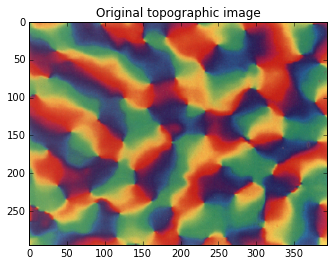

In [3]:
# Orientation preference map: for now, use k-means on Blasdel image
rgb_img = mpimg.imread('v1-topology-blasdel-figure6.png')

plt.figure()
plt.imshow(rgb_img)
plt.title('Original topographic image')

lab_img = color.rgb2lab(rgb_img) # convert to L*a*b* colourspace

ab = lab_img[:,:,1:]
n_rows = np.shape(ab)[0]
n_cols = np.shape(ab)[1]

ab = np.reshape(ab, (n_rows*n_cols, 2))
n_colours = 6

centroids, labels = kmeans2(ab, n_colours, iter=3)

labels = np.reshape(labels, (n_rows, n_cols))

rgb_labels = np.tile(labels[:,:,None], [1,1,3])

OP_range = np.linspace(0, 180, n_colours)
full_OP_map = np.copy(labels)

for i in range(n_colours):
    seg_img = np.copy(rgb_img)
    seg_img[rgb_labels != i] = 0  
    
    # assign an orientation preference (degrees) based on segmentation
    full_OP_map[full_OP_map == i] = OP_range[i]
    
    # Show the individual segmented images:
#     plt.figure()
#     plt.imshow(seg_img)


In [4]:
# Determine the connection probabilities 

N_pairs = 75 # no. of E/I pairs to a side of a grid
field_size = 16. # size of field to a side (degrees)
dx = field_size / N_pairs

xy_range = np.linspace(0, field_size, N_pairs, False)
# xy_range = np.linspace(-field_size/2, field_size/2, N_pairs)

xv, yv = np.meshgrid(xy_range, xy_range) # x and y grid values (degrees)

# sample the OP map uniformly 
min_dim = np.min(np.shape(full_OP_map))
o_samples = np.round(np.linspace(0, min_dim-1, N_pairs))

xo, yo = np.meshgrid(o_samples, o_samples)

xo = xo.astype(int)
yo = yo.astype(int)

OP_map = full_OP_map[yo,xo]

# Rodent map
# OP_map = np.floor(np.random.rand(N_pairs, N_pairs)*180)

# Connection weight parameters (from supp. materials S1.1.2):
kappa_E = 0.1
kappa_I = 0.5
J_EE = 0.1
J_IE = 0.38
J_EI = 0.089
J_II = 0.096

sig_EE = 8*dx
sig_IE = 12*dx
sig_EI = 4*dx
sig_II = 4*dx
sig_ori = 45

# calculate probability of no connections for each neuron (sparse connectivity)

G_EE = np.zeros((N_pairs**2, N_pairs, N_pairs))
G_IE = np.copy(G_EE)

# may not need these
G_EI = np.copy(G_EE)
G_II = np.copy(G_EE)

G_ori = np.copy(G_EE)

pW_EE = np.copy(G_EE)
pW_IE = np.copy(G_EE)
pW_EI = np.copy(G_EE)
pW_II = np.copy(G_EE)

rnd_EE = np.copy(G_EE)
rnd_IE = np.copy(G_EE)
rnd_EI = np.copy(G_EE)
rnd_II = np.copy(G_EE)
np.random.seed(1)

# iterate through each E/I pair:
for i in range(N_pairs):
    for j in range(N_pairs):
        G_EE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_EE)
        G_IE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_IE)
        
        # do we need these? it doesn't appear that way in the methods...
        G_EI[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_EI)
        G_II[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_II)
        
        G_ori[N_pairs*i+j,:,:] = G(OP_map[j,i], OP_map, sig_ori)
        rnd_EE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_IE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_EI[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_II[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)

for i in range(N_pairs**2):
    pW_EE[i,:,:] = kappa_E * np.multiply(G_EE[i,:,:], G_ori[i,:,:])
    pW_IE[i,:,:] = kappa_E * np.multiply(G_IE[i,:,:], G_ori[i,:,:])
#     pW_EI[i,:,:] = kappa_I * np.multiply(G_EE[i,:,:], G_ori[i,:,:])
#     pW_II[i,:,:] = kappa_I * np.multiply(G_IE[i,:,:], G_ori[i,:,:])

    pW_EI[i,:,:] = kappa_I * np.multiply(G_EI[i,:,:], G_ori[i,:,:])
    pW_II[i,:,:] = kappa_I * np.multiply(G_II[i,:,:], G_ori[i,:,:])
    
# find zero-weighted connections:
W_EE = np.ones((N_pairs**2, N_pairs, N_pairs))
W_IE = np.copy(W_EE)
W_EI = np.copy(W_EE)
W_II = np.copy(W_EE)

W_EE[pW_EE<rnd_EE] = 0
W_IE[pW_IE<rnd_IE] = 0
W_EI[pW_EI<rnd_EI] = 0
W_II[pW_II<rnd_II] = 0

u_EE = mean_connections(W_EE)
u_IE = mean_connections(W_IE)
u_EI = mean_connections(W_EI)
u_II = mean_connections(W_II)

In [5]:
u_ab = np.mean([u_EE, u_EI, u_IE, u_II])
print u_EE, u_EI, u_IE, u_II, u_ab

print xv
print '=========='
print yv

15.3201777778 25.5281777778 30.5344 25.4851555556 24.2169777778
[[  0.           0.21333333   0.42666667 ...,  15.36        15.57333333
   15.78666667]
 [  0.           0.21333333   0.42666667 ...,  15.36        15.57333333
   15.78666667]
 [  0.           0.21333333   0.42666667 ...,  15.36        15.57333333
   15.78666667]
 ..., 
 [  0.           0.21333333   0.42666667 ...,  15.36        15.57333333
   15.78666667]
 [  0.           0.21333333   0.42666667 ...,  15.36        15.57333333
   15.78666667]
 [  0.           0.21333333   0.42666667 ...,  15.36        15.57333333
   15.78666667]]
[[  0.           0.           0.         ...,   0.           0.           0.        ]
 [  0.21333333   0.21333333   0.21333333 ...,   0.21333333   0.21333333
    0.21333333]
 [  0.42666667   0.42666667   0.42666667 ...,   0.42666667   0.42666667
    0.42666667]
 ..., 
 [ 15.36        15.36        15.36       ...,  15.36        15.36        15.36      ]
 [ 15.57333333  15.57333333  15.57333333 ...,

Neuron O preference:  72


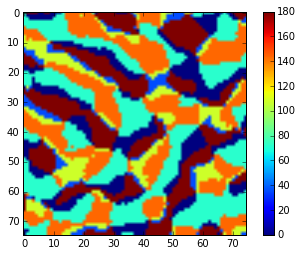

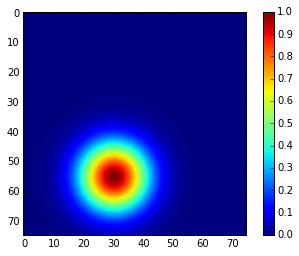

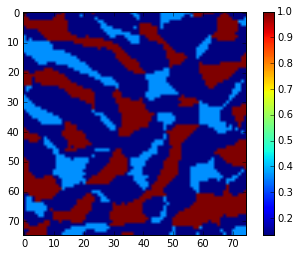

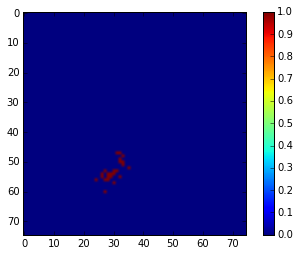

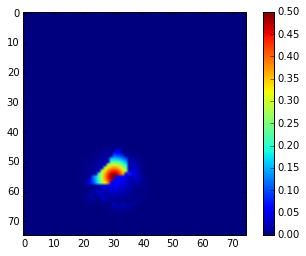

In [6]:
# Show the connection maps (optional to run)
nx = 30
ny = 55
neuron_index = ny+nx*N_pairs
plt.figure()
plt.imshow(OP_map)
plt.colorbar()

plt.figure()
plt.imshow(G_EE[neuron_index,:,:])
plt.colorbar()

plt.figure()
plt.imshow(G_ori[neuron_index,:,:])
plt.colorbar()

plt.figure()
plt.imshow(W_EI[neuron_index,:,:])
plt.colorbar()

plt.figure()
plt.imshow(pW_II[neuron_index,:,:])
plt.colorbar()

print 'Neuron O preference: ', OP_map[ny,nx] 

In [7]:
# For non-zero connections, determine the weight 
W_EE[W_EE != 0] = np.random.normal(J_EE, 0.25*J_EE, W_EE[W_EE!=0].size)
W_IE[W_IE != 0] = np.random.normal(J_IE, 0.25*J_IE, W_IE[W_IE!=0].size)
W_EI[W_EI != 0] = np.random.normal(J_EI, 0.25*J_EI, W_EI[W_EI!=0].size)
W_II[W_II != 0] = np.random.normal(J_II, 0.25*J_II, W_II[W_II!=0].size)

# Set negative weights to zero:
W_EE[W_EE < 0] = 0
W_IE[W_IE < 0] = 0
W_EI[W_EI < 0] = 0
W_II[W_II < 0] = 0

# "Weights of a given type 'b' onto each unit 
# are then scaled so that all units of a given type 'a' receive the same 
# total type b synaptic weight, equal to Jab times the mean number of 
# connections received under p (Wab(x, x′) ̸= 0)"
for i in range(N_pairs**2):
    if np.all(W_EE[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_EE[i,:,:] = W_EE[i,:,:]*J_EE*u_EE/np.sum(W_EE[i,:,:])
    
    if np.all(W_IE[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_IE[i,:,:] = W_IE[i,:,:]*J_IE*u_IE/np.sum(W_IE[i,:,:])

    if np.all(W_EI[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_EI[i,:,:] = W_EI[i,:,:]*J_EI*u_EI/np.sum(W_EI[i,:,:])

    if np.all(W_II[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_II[i,:,:] = W_II[i,:,:]*J_II*u_II/np.sum(W_II[i,:,:])

In [8]:
samples = np.floor(np.random.rand(10)*N_pairs**2)

print 'EE should sum to ', J_EE*u_EE

for i in range(10):
    print 'Neuron %d:' % samples[i]
    print np.sum(W_EE[samples[i],:,:])
    print '=================='


EE should sum to  1.53201777778
Neuron 1508:
1.53201777778
Neuron 5508:
1.53201777778
Neuron 786:
1.53201777778
Neuron 1702:
1.53201777778
Neuron 2646:
1.53201777778
Neuron 4970:
1.53201777778
Neuron 5022:
1.53201777778
Neuron 3921:
1.53201777778
Neuron 365:
1.53201777778
Neuron 5048:
1.53201777778


In [9]:
# Model parameters (from supplementary methods)

k   = np.random.normal(0.012, 0.05*0.012, (N_pairs, N_pairs))
n_E = np.random.normal(2.0, 0.05*2.0, (N_pairs, N_pairs)) 
n_I = np.random.normal(2.2, 0.05*2.2, (N_pairs, N_pairs))
sig_FF = 32
sig_RF = dx

tau_E = np.random.normal(0.02, 0.05*0.02, (N_pairs, N_pairs))
tau_I = np.random.normal(0.01, 0.05*0.01, (N_pairs, N_pairs))

In [10]:
def generate_ext_stimulus(ori, size, centre, full_frame=False):
    G_FF = G(ori, OP_map, sig_FF)
    
    if full_frame==True:
        h = G_FF
    else:
        x_distance = np.abs(xv - centre[0])
        y_distance = np.abs(yv - centre[1])
        dist = np.sqrt(x_distance**2 + y_distance**2)
        s_l = stimulus_size(dist, size, sig_RF)
#         h = np.multiply( s_l, G_FF )
        h = s_l * G_FF
        
    return h

In [11]:
def run_simulation( dt, timesteps, c, h, init_cond=[np.zeros((N_pairs, N_pairs)),np.zeros((N_pairs, N_pairs))]):

    r_E = np.zeros((timesteps, N_pairs, N_pairs))
    r_I = np.copy(r_E)

    # add initial conditions:
    r_E[0,:,:] = init_cond[0]
    r_I[0,:,:] = init_cond[1]

    I_E = np.zeros((timesteps, N_pairs, N_pairs))
    I_I = np.copy(I_E)
    # rSS_E = np.copy(I_E)
    # rSS_I = np.copy(I_I)

    for t in range(1,timesteps):
        # Input drive from external input and network
#         for i in range(N_pairs):
#             for j in range(N_pairs):
#                 I_E[t,j,i] = c*h[j,i] + np.sum( np.multiply( W_EE[i*N_pairs+j,:,:], r_E[t-1,:,:]) ) - np.sum( np.multiply( W_EI[i*N_pairs+j,:,:], r_I[t-1,:,:]) )
#                 I_I[t,j,i] = c*h[j,i] + np.sum( np.multiply( W_IE[i*N_pairs+j,:,:], r_E[t-1,:,:]) ) - np.sum( np.multiply( W_II[i*N_pairs+j,:,:], r_I[t-1,:,:]) )
        I_E[t,:,:] = c*h + np.sum( np.reshape(np.multiply(W_EE, r_E[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T - np.sum( np.reshape(np.multiply(W_EI, r_I[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T
        I_I[t,:,:] = c*h + np.sum( np.reshape(np.multiply(W_IE, r_E[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T - np.sum( np.reshape(np.multiply(W_II, r_I[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T

        # steady state firing rates - power law I/O
        rSS_E = np.multiply(k, np.power(np.fmax(0,I_E[t,:,:]), n_E))
        rSS_I = np.multiply(k, np.power(np.fmax(0,I_I[t,:,:]), n_I))

        # set negative steady state rates to zero
        rSS_E[rSS_E < 0] = 0
        rSS_I[rSS_I < 0] = 0

        # instantaneous firing rates approaching steady state
        r_E[t,:,:] = r_E[t-1,:,:] + dt*(np.divide(-r_E[t-1,:,:]+rSS_E, tau_E))
        r_I[t,:,:] = r_I[t-1,:,:] + dt*(np.divide(-r_I[t-1,:,:]+rSS_I, tau_I))
        
    return [r_E, r_I, I_E, I_I]

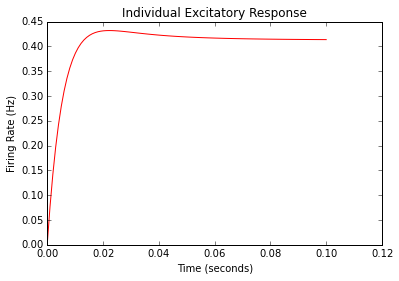

In [13]:
# run a single simulation for testing 

h = generate_ext_stimulus(45, 16, (8,8))
dt = 0.001
timesteps = 100
c = 40
[r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h)

plt.figure()
plt.plot(np.linspace(0,0.1,100), r_E[:,37,37],'r')
plt.title('Individual Excitatory Response')
plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')

2.38367814597 11.0059464847


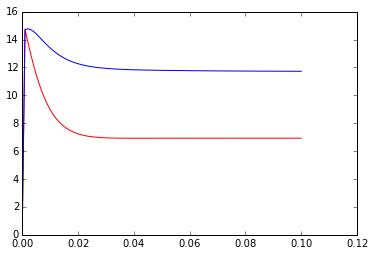

In [19]:
plt.figure()
# plt.hold(True)
plt.plot(np.linspace(0,0.1,100), I_E[:,37,37], 'r', np.linspace(0,0.1,100), I_I[:,37,37], 'b') 

print np.max(r_E), np.max(r_I)

In [15]:
if np.isnan(r_E).any():
    print 'List of non-overflow neurons: '
    for i in range(N_pairs):
        for j in range(N_pairs):
            if np.isnan(r_E[:,i,j]).any() == False:
                print (i,j)
else:
    print 'No neurons overflow'

No neurons overflow


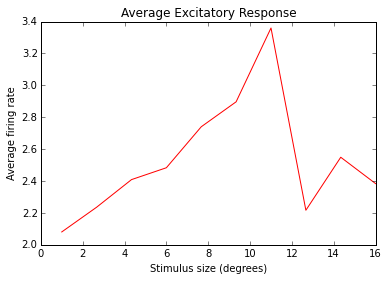

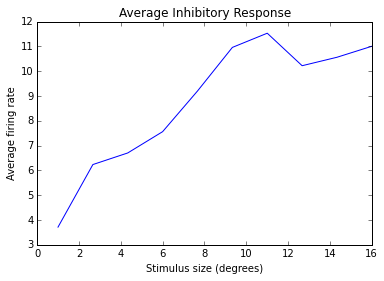

In [16]:
# run simulations to reproduce mean length tuning curves, figure 6E
# We want to use neurons that demonstrate significant surround suppression - higher than 0.25
# (this will take a long time to run)
size_range = np.linspace(1,16,10) # size
c = 40
stim_ori = 45 # degrees
centre = (8,8)
h_range = np.zeros((len(size_range), N_pairs, N_pairs))

for i in range(len(size_range)):
    h_range[i,:,:] = generate_ext_stimulus(stim_ori, size_range[i], centre)

dt = 0.001
timesteps = 100

# store all the firing rates for every trial
results_E = np.zeros((len(size_range), timesteps, N_pairs, N_pairs))
results_I = np.copy(results_E)

for i in range(len(size_range)):
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h_range[i])
                   
    results_E[i,:,:,:] = r_E
    results_I[i,:,:,:] = r_I

833
186


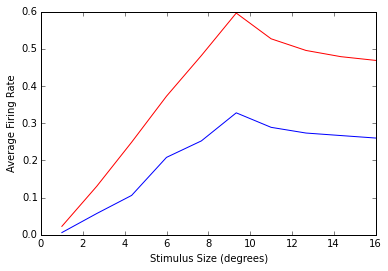

In [17]:
# Find which units demonstrate SSI > 0.25:
# first, find max firing rates for stimuli shorter than 2/3 * 16 degrees:
trials = size_range[ size_range < 2./3*field_size ].size 

r_max_E = np.max( np.max( results_E[:trials, :, :, :], 1), 0 )
r_full_E = np.max( results_E[-1, :, :, :], 0)

SSI_E = (r_max_E - r_full_E) / r_max_E

print SSI_E[SSI_E > 0.25].size

r_max_I = np.max( np.max( results_I[:trials, :, :, :], 1), 0 )
r_full_I = np.max( results_I[-1, :, :, :], 0)

SSI_I = (r_max_I - r_full_I) / r_max_I

print SSI_I[SSI_I > 0.25].size

y_I, x_I = np.where(SSI_I > 0.25)
y_E, x_E = np.where(SSI_E > 0.25)

avg_r_E = np.zeros(len(size_range))
avg_r_I = np.copy(avg_r_E)

for i in range(len(size_range)):
    avg_r_E[i] = np.mean( results_E[i, :, y_E, x_E] )
    avg_r_I[i] = np.mean( results_I[i, :, y_I, x_I] )
    
plt.figure()
plt.plot(size_range, avg_r_E, 'r', size_range, avg_r_I, 'b')
plt.ylabel('Average Firing Rate')
plt.xlabel('Stimulus Size (degrees)')

In [18]:
print SSI_I.shape, SSI_E.shape

(75, 75) (75, 75)


[ 23.  56.  19.  63.  43.  72.  45.   6.  62.  42.] [  3.  60.  36.  13.  17.  23.  28.  17.  42.  73.]


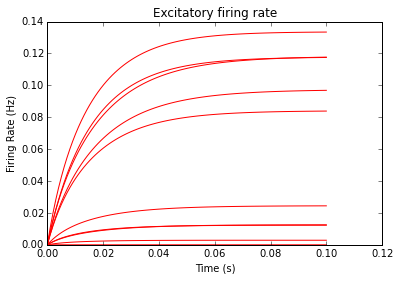

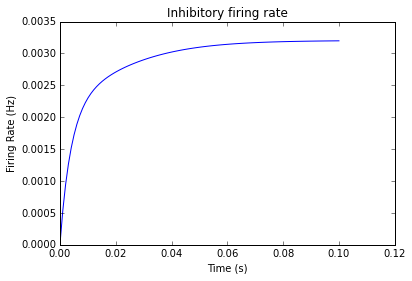

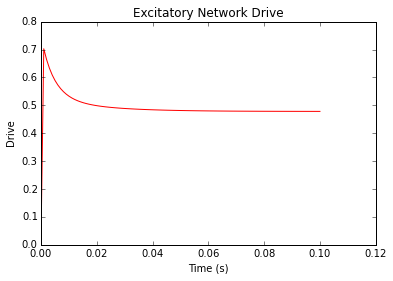

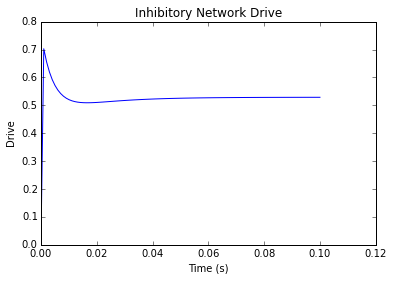

In [58]:
# Plotting results
n_plots = 10
x = np.floor(N_pairs*np.random.rand(n_plots))
y = np.floor(N_pairs*np.random.rand(n_plots))

print x,y

plt.figure()
plt.hold(True)
t_range = np.linspace(0,timesteps*dt, timesteps)

for i in range(n_plots):
    plt.plot( t_range, r_E[:,x[i],y[i]], 'r' )
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Excitatory firing rate')
plt.show()

plt.figure()
plt.plot(t_range, r_I[:,x[0],y[0]] )
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Inhibitory firing rate')

plt.figure()
plt.plot(t_range, I_E[:,x[0],y[0]], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Drive')
plt.title('Excitatory Network Drive')

plt.figure()
plt.plot(t_range, I_I[:,x[0],y[0]])
plt.xlabel('Time (s)')
plt.ylabel('Drive')
plt.title('Inhibitory Network Drive')